## `PyFixest` on professional-tier GPUs 

We test two back-ends for the iterative alternating-projections component of the fixed-effects regression on an Nvidia A100 GPU with 40 GB VRAM (a GPU that one typically wouldn't have installed to play graphics-intensive videogames on consumer hardware). `numba` benchmarks are run on a 12-core xeon CPU. 

The Jax backend exhibits major performance improvements over numba in large problems. 

In [1]:
import jax
import jax.numpy as jnp

jax.devices()

[CudaDevice(id=0)]

In [2]:
jnp.ones(10).devices()

{CudaDevice(id=0)}

When jax is configured on a GPU-equipped machine, arrays are created on the GPU by default.

In [3]:
!nvidia-smi

Sun Jan 12 15:23:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:90:1C.0 Off |                    0 |
| N/A   43C    P0              79W / 400W |  30812MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

/root/miniconda3/envs/jaxgpu/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Jax pre-allocates 75% VRAM

In [4]:
import time
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import nbinom
from tqdm import tqdm

np.random.seed(42)

In [5]:
import pyfixest as pf
from pyfixest.estimation.demean_ import demean
from pyfixest.estimation.demean_jax_ import demean_jax

In [ ]:
%load_ext watermark
%watermark --iversions

seaborn   : 0.13.2
tqdm      : 4.67.1
numpy     : 2.0.2
pyfixest  : 0.27.0
jax       : 0.4.35
matplotlib: 3.9.2
pandas    : 2.2.3



First, we define a function to simulate a test data set which closely mimics the data generating process in the original fixest benchmarks 
that produced the data for [this figure](https://raw.githubusercontent.com/lrberge/fixest/refs/heads/master/vignettes/images/benchmark_gaussian.png).

In one slight adjustment, we allow to vary the number of regressors `k`, which in the original fixest dgp is always set to 1. 

In [7]:
def generate_test_data(size: int, k: int = 2):
    """
    Generate benchmark data for pyfixest on GPU (similar to the R fixest benchmark data).

    Args:
        size (int): The number of observations in the data frame.
        k (int): The number of covariates in the data frame.

    Returns
    -------
        pd.DataFrame: The generated data frame for the given size.
    """
    # Constants
    all_n = [1000 * 10**i for i in range(5)]
    a = 1
    b = 0.05

    n = all_n[size - 1]

    dum_all = []
    nb_dum = [n // 20, int(np.sqrt(n)), int(n**0.33)]

    dum_all = np.zeros((n, 3))
    dum_all[:, 0] = np.random.choice(nb_dum[0], n, replace=True)
    dum_all[:, 1] = np.random.choice(nb_dum[1], n, replace=True)
    dum_all[:, 2] = np.random.choice(nb_dum[2], n, replace=True)
    dum_all = dum_all.astype(int)

    X1 = np.random.normal(size=n)
    X2 = X1**2

    mu = a * X1 + b * X2

    for m in range(3):
        coef_dum = np.random.normal(size=nb_dum[m])
        mu += coef_dum[dum_all[:, m]]

    mu = np.exp(mu)
    y = nbinom.rvs(0.5, 1 - (mu / (mu + 0.5)), size=n)

    X_full = np.column_stack((X1, X2))
    base = pd.DataFrame(
        {
            "y": y,
            "ln_y": np.log(y + 1),
            "X1": X1,
            "X2": X2,
        }
    )

    if k > 2:
        X = np.random.normal(size=(n, k - 2))
        X_df = pd.DataFrame(X, columns=[f"X{i}" for i in range(3, k + 1, 1)])
        base = pd.concat([base, X_df], axis=1)
        X_full = np.column_stack((X_full, X))

    for m in range(3):
        base[f"dum_{m + 1}"] = dum_all[:, m]

    weights = np.random.uniform(0, 1, n)
    return base, y, X_full, dum_all, weights

In [8]:
df, Y, X, f, weights = generate_test_data(1)

In [9]:
%%time
m0 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="numba")
m0.summary()

###

Estimation:  OLS
Dep. var.: ln_y, Fixed effects: dum_1
Inference:  CRV1
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.500 |        0.052 |     9.691 |      0.000 |  0.396 |   0.603 |
---
RMSE: 1.095 R2: 0.298 R2 Within: 0.159 
CPU times: user 6.5 s, sys: 79.4 ms, total: 6.58 s
Wall time: 6.53 s


In [10]:
%%time
m1 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="jax")
m1.summary()

###

Estimation:  OLS
Dep. var.: ln_y, Fixed effects: dum_1
Inference:  CRV1
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.500 |        0.052 |     9.691 |      0.000 |  0.396 |   0.603 |
---
RMSE: 1.095 R2: 0.298 R2 Within: 0.159 
CPU times: user 239 ms, sys: 54.7 ms, total: 294 ms
Wall time: 366 ms


The first-compute time is considerably shorter for JAX; it doesn't have cold-start overheads to the same extent as numba.

## Benchmark Function 

We know define a single function to run a benchmark for a given sample size `size = i x 1000`, number of regressors `k`, solver, 
and demeaning backend. Additionally, the function allows us to specify a set of fixed effects and if we want to run benchmarks only 
for a full call to `pf.feols()`, or if we additionally want to benchmark the demeaning process. 

In [ ]:
def run_standard_benchmark(
    fixed_effect,
    demeaner_backend,
    size=1,
    k=1,
    solver="np.linalg.lstsq",
    skip_demean_benchmark=True,
    nrep=5,
):
    """
    Run the fixest standard benchmark fixed effect models. This is the function the benchmarks
    will loop over.

    Args:
        fixed_effect (str): The fixed effect to use. Must be a list of variables as "dum_1", "dum_1+dum_2", or "dum_1+dum_2+dum_3", etc.
        demeaner_backend (str): The backend to use for demeaning. Must be "numba" or "jax".
        size (int): The size of the data to generate. Must be between 1 and 5. For 1, N = 1000, for 2, N = 10000, etc.
        k_vals (int): The number of covariates to generate.
        solver (str): The solver to use for the estimation. Must be "np.linalg.lstsq". "jax" currently throws an error.
        skip_demean_benchmark (bool): Whether to skip the "pure" demean benchmark. Default is True. Only the full call
            to feols is benchmarked.

    """
    assert fixed_effect in ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"]

    # one fixed effect
    res = []

    fml_base = "ln_y ~ X1"
    fml = f"{fml_base} | {fixed_effect}"

    # warmup
    df, _, X, f, weights = generate_test_data(1)
    pf.feols(
        fml,
        data=df,
        demeaner_backend=demeaner_backend,
        store_data=False,
        copy_data=False,
        solver=solver,
    )

    if k > 1:
        xfml = "+".join([f"X{i}" for i in range(2, k + 1, 1)])
        fml = f"{fml_base} + {xfml} | {fixed_effect}"
    else:
        fml = f"{fml_base} + X1 | {fixed_effect}"

    for rep in range(nrep):
        df, Y, X, f, weights = generate_test_data(size=size, k=k)

        tic1 = time.time()
        pf.feols(
            fml,
            data=df,
            demeaner_backend=demeaner_backend,
            store_data=False,
            copy_data=False,
            solver=solver,
        )
        tic2 = time.time()

        full_feols_timing = tic2 - tic1

        demean_timing = np.nan
        if not skip_demean_benchmark:
            YX = np.column_stack((Y.reshape(-1, 1), X))
            tic3 = time.time()
            if demeaner_backend == "jax":
                _, _ = demean_jax(YX, f, weights, tol=1e-10)
            else:
                _, _ = demean(YX, f, weights, tol=1e-10)
            tic4 = time.time()
            demean_timing = tic4 - tic3

        res.append(
            pd.Series(
                {
                    "method": "feols",
                    "solver": solver,
                    "demeaner_backend": demeaner_backend,
                    "n_obs": df.shape[0],
                    "k": k,
                    "G": len(fixed_effect.split("+")),
                    "rep": rep + 1,
                    "full_feols_timing": full_feols_timing,
                    "demean_timing": demean_timing,
                }
            )
        )

    return pd.concat(res, axis=1).T

In [13]:
# test run numba
run_standard_benchmark(fixed_effect="dum_1", demeaner_backend="numba", size=1, k=1)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,numba,1000,1,1,1,0.113831,NaN
1,feols,np.linalg.lstsq,numba,1000,1,1,2,0.109568,NaN
2,feols,np.linalg.lstsq,numba,1000,1,1,3,0.140634,NaN
3,feols,np.linalg.lstsq,numba,1000,1,1,4,0.107976,NaN
4,feols,np.linalg.lstsq,numba,1000,1,1,5,0.108512,NaN


In [14]:
# test run jax
run_standard_benchmark(fixed_effect="dum_1", demeaner_backend="jax", size=1, k=1)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,jax,1000,1,1,1,0.123767,NaN
1,feols,np.linalg.lstsq,jax,1000,1,1,2,0.110617,NaN
2,feols,np.linalg.lstsq,jax,1000,1,1,3,0.111191,NaN
3,feols,np.linalg.lstsq,jax,1000,1,1,4,0.109355,NaN
4,feols,np.linalg.lstsq,jax,1000,1,1,5,0.110047,NaN


In [ ]:
def run_all_benchmarks(size_list, k_list):
    """
    Run all the benchmarks.

    Args:
        size_list (list): The list of sizes to run the benchmarks on. 1-> 1000, 2-> 10000, ..., 5-> 10_000_000
        k_list (list): The list of k values to run the benchmarks on.
    """
    res = pd.DataFrame()

    all_combinations = list(
        product(
            ["numba", "jax", "rust", "cupy64", "cupy32", "scipy"],  # demeaner_backend
            ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"],  # fixef
            size_list,  # size
            k_list,  # k
            ["np.linalg.lstsq"],  # solver
        )
    )

    with tqdm(total=len(all_combinations), desc="Running Benchmarks") as pbar:
        for demeaner_backend, fixef, size, k, solver in all_combinations:
            res = pd.concat(
                [
                    res,
                    run_standard_benchmark(
                        solver=solver,
                        fixed_effect=fixef,
                        demeaner_backend=demeaner_backend,
                        size=size,
                        k=k,
                    ),
                ],
                axis=0,
            )
            pbar.update(1)  # Update the progress bar after each iteration

    return res

## Run Benchmarks

In [16]:
%%time
res_all = run_all_benchmarks(
    size_list=[1, 2, 3, 4, 5],  # for N = 1000, 10_000, 100_000, 1_000_000, 10_000_000
    k_list=[1, 10, 50, 100],  # for k = 1, 10, 50, 100
)

Running Benchmarks: 100%|██████████| 120/120 [1:54:24<00:00, 57.20s/it] 

CPU times: user 3h 18min 29s, sys: 26min 39s, total: 3h 45min 9s
Wall time: 1h 54min 24s


In [18]:
df = (
    res_all.drop(["rep", "solver"], axis=1)
    .groupby(["method", "demeaner_backend", "k", "G", "n_obs"])
    .mean()
    .reset_index()
)
df

,method,demeaner_backend,k,G,n_obs,full_feols_timing,demean_timing
0,feols,jax,1,1,1000,0.132004,NaN
1,feols,jax,1,1,10000,0.162957,NaN
2,feols,jax,1,1,100000,0.20829,NaN
3,feols,jax,1,1,1000000,0.428737,NaN
4,feols,jax,1,1,10000000,3.438257,NaN
...,...,...,...,...,...,...,...
115,feols,numba,100,3,1000,0.199722,NaN
116,feols,numba,100,3,10000,0.280761,NaN
117,feols,numba,100,3,100000,0.942488,NaN
118,feols,numba,100,3,1000000,8.141236,NaN


In [19]:
df.to_csv("gpu_runtime_res.csv")

## Visualize Results

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("gpu_runtime_res.csv")
df.head()

,Unnamed: 0,method,demeaner_backend,k,G,n_obs,full_feols_timing,demean_timing
0,0,feols,jax,1,1,1000,0.132004,NaN
1,1,feols,jax,1,1,10000,0.162957,NaN
2,2,feols,jax,1,1,100000,0.208290,NaN
3,3,feols,jax,1,1,1000000,0.428737,NaN
4,4,feols,jax,1,1,10000000,3.438257,NaN


In [4]:
df["G"] = df["G"].map({1: "n_fixef = 1", 2: "n_fixef = 2", 3: "n_fixef = 3"})
df["n_obs"] = df["n_obs"].astype(str)

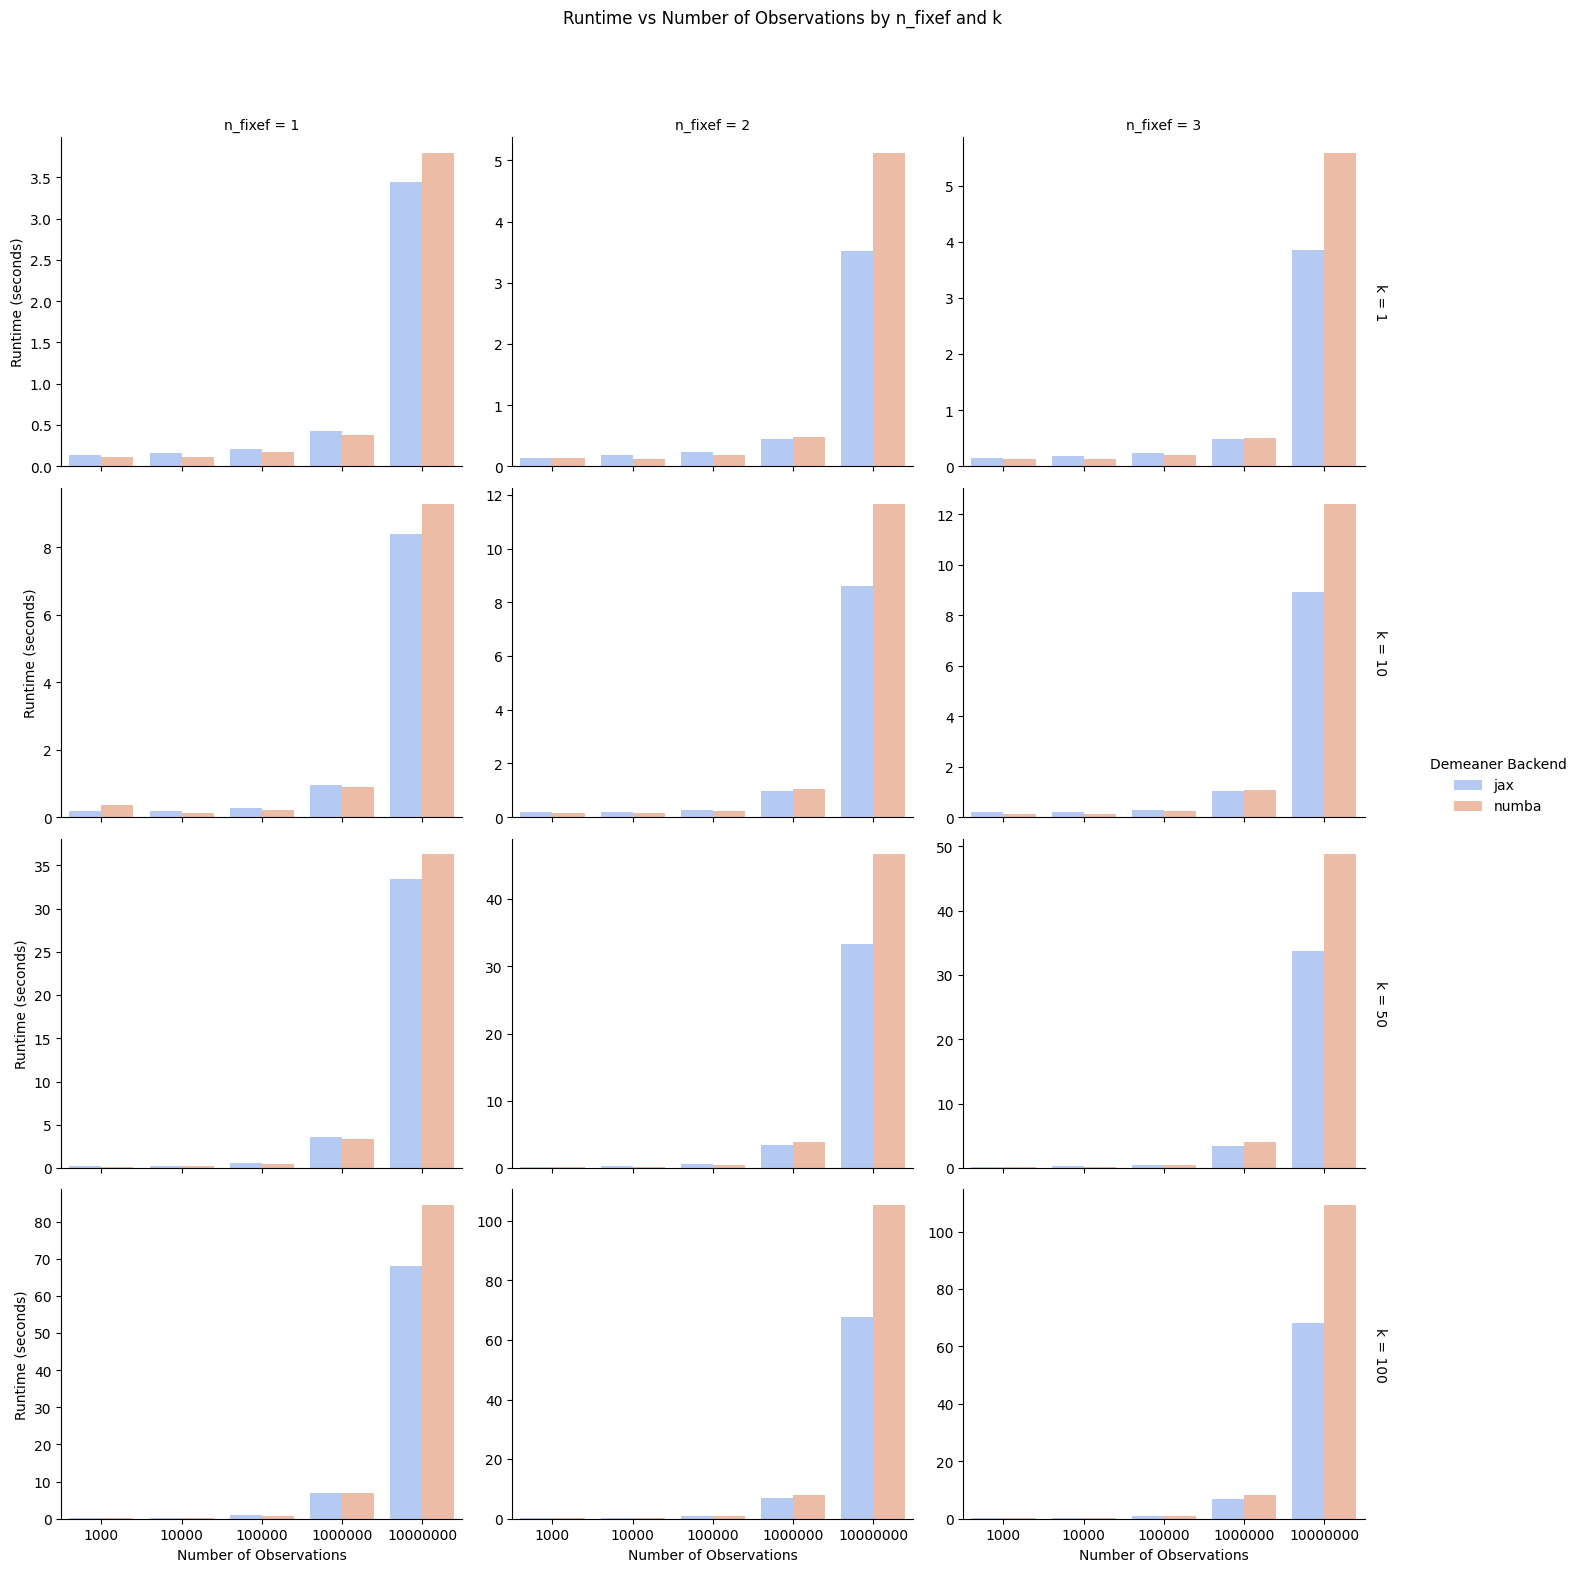

In [5]:
# Dynamically determine unique values for order and hue_order
n_obs_order = sorted(df["n_obs"].unique(), key=lambda x: int(x))  # Sort as integers
demeaner_backend_order = df["demeaner_backend"].unique()

custom_palette = sns.color_palette("coolwarm", n_colors=2)

# Create the FacetGrid with reordered columns and rows
g = sns.FacetGrid(
    df,
    col="G",  # G (n_fixef) increases left to right
    row="k",  # k increases top to bottom
    margin_titles=True,
    height=4,
    aspect=1.2,
    col_order=["n_fixef = 1", "n_fixef = 2", "n_fixef = 3"],  # Ensure correct order
    sharey=False,
)

# Plot the bar chart for each facet with the custom palette
g.map(
    sns.barplot,
    "n_obs",
    "full_feols_timing",
    "demeaner_backend",
    order=n_obs_order,  # Dynamic order for n_obs
    hue_order=demeaner_backend_order,  # Dynamic hue order for demeaner_backend
    errorbar=None,  # Suppress error bars
    palette=custom_palette,
)

# Add legend and adjust layout
g.add_legend(title="Demeaner Backend")
g.set_axis_labels("Number of Observations", "Runtime (seconds)")
g.set_titles(row_template="k = {row_name}", col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Runtime vs Number of Observations by n_fixef and k")

# Show plot
plt.show()